<a href="https://colab.research.google.com/github/Guillem96/activity-recognition/blob/master/notebooks/Dense%20Trajectories%20Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf taxi
!curl -O ftp://ftp.ira.uka.de/pub/vid-text/image_sequences/taxi/taxi.zip
!unzip -q taxi.zip
!rm taxi.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1454k  100 1454k    0     0   356k      0  0:00:04  0:00:04 --:--:--  356k


In [2]:
from pathlib import Path

import cv2 as cv
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

In [3]:
taxis_fnames = sorted(list(Path('taxi').iterdir()))
print(f'Number of frames: {len(taxis_fnames)}')

Number of frames: 41


## Tracking a point between 2 images


In [4]:
rand_idx = np.random.randint(len(taxis_fnames) - 3, size=(1,)).item()

taxi1 = Image.open(taxis_fnames[rand_idx])
taxi2 = Image.open(taxis_fnames[rand_idx + 3])

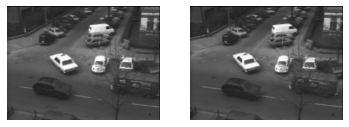

In [5]:
plt.subplot(121)
plt.imshow(taxi1, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(taxi2, cmap='gray')
plt.axis('off');

In [6]:
flow = cv.calcOpticalFlowFarneback(np.array(taxi1), 
                                   np.array(taxi2), 
                                   None, 0.5, 3, 15, 3, 5, 1.2, 0)

Feature points are sampled on a grid spaced by W pixels and tracked in each scale separately. Experimentally, we observed that a sampling step size of
$W = 5$ is dense enough to give good results.

In [7]:
W = 5

$ P_{t + 1} = (x_{t + 1}, y_{t+1}) = (x_{t}, y_{t}) + (M * w)$

where $M$ is a median filtering kernel and $w$ is the two frames optical flow

In [14]:
def sample_points(height, width):
    p_x, p_y = np.arange(0, width, W), np.arange(height, -1, -W)
    r_p_y = p_y.reshape(-1, 1).repeat(p_x.shape, -1).reshape(-11, p_x.shape[0], 1)
    r_p_x = p_x.reshape(1, -1, 1).repeat(p_y.shape[0], 0)
    return np.concatenate([r_p_y, r_p_x], -1).reshape(-1, 2)

pt = sample_points(*taxi1.size[::-1])
pt_1 = pt + np.take(cv.medianBlur(flow, W), pt)

We plot a subsample of trajectories

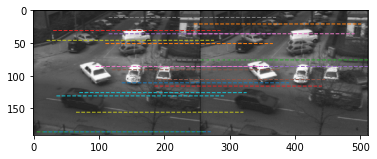

In [16]:
rand_samples = np.random.randint(0, high=pt.shape[0], size=(20,))
plt.imshow(np.concatenate([np.array(taxi1), np.array(taxi2)], axis=1), 
           cmap='gray')
for point1, point2 in zip(pt[rand_samples], pt_1[rand_samples]):
    plt.plot([point1[1], point2[1] + 256], 
             [point1[0], point2[0]],
             '--', linewidth=1)

## Working with a whole video

In [17]:
L = 15 #@param {"type": "slider", "min": 3, "max": 20 }

In [18]:
def display_video(images):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(images[0], cmap='gray')
    plt.close()

    def init():
        im.set_data(images[0])

    def animate(i):
        im.set_data(images[i])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(images), interval=50)
    display(HTML(anim.to_html5_video()))

rand_idx = np.random.randint(0, high=len(taxis_fnames) - L, size=(1,)).item()
images = [Image.open(o) for o in taxis_fnames[rand_idx: rand_idx + L]]
display_video(images)

Sample the initial points to track

In [19]:
pt = sample_points(*taxi1.size[::-1])

We compute the optical flow for each pair of frames

In [20]:
def compute_of(frame1, frame2):
    return cv.calcOpticalFlowFarneback(np.array(frame1), 
                                       np.array(frame2), 
                                       None, 0.5, 3, 15, 3, 5, 1.2, 0)
ofs = [compute_of(a, b) for a, b in zip(images[:-1], images[1:])]

Now, we start at the initial frame with "known" sampled points, and we track them frame after frame using the filtered optical flow.

In [21]:
def track_point(points, of):
    return pt + np.take(cv.medianBlur(flow, W), pt)

tracked_points = [pt]
for of in ofs:
    pt_1 = track_point(tracked_points[-1], of)
    tracked_points.append(pt_1)

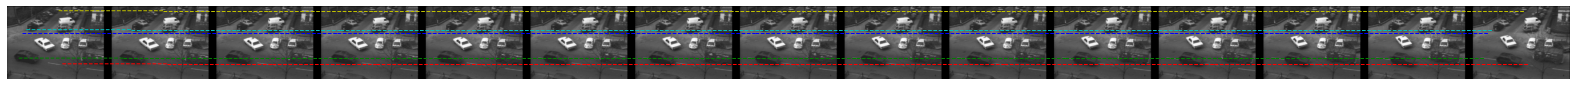

In [55]:
margin_in_pixels = 20
final_image = np.zeros((taxi1.size[1], taxi1.size[0] * L + margin_in_pixels * (L - 1)))

for i, im in enumerate(images):
    start_width = i * taxi1.size[0] + i * margin_in_pixels
    end_width = start_width + taxi1.size[0]
    final_image[:, start_width: end_width] = np.array(im)

plt.figure(figsize=(28, 28))
plt.imshow(final_image, cmap='gray')
plt.axis('off');

rand_samples = np.random.randint(0, high=tracked_points[0].shape[0], size=(5,))
colors = 'rgbcy'
for i, (points_frame_i, points_frame_j) in enumerate(zip(tracked_points[:-1], tracked_points[1:])):
    w_offset = i * taxi1.size[0] + i * margin_in_pixels
    for i, (p1, p2) in enumerate(zip(points_frame_i[rand_samples], points_frame_j[rand_samples])):
        plt.plot([p1[1] + w_offset, p2[1] + w_offset + taxi1.size[0] + margin_in_pixels], 
                 [p1[0], p2[0]],
                 '--', color=colors[i], linewidth=1)